In [11]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output  # Only for iPython

In [12]:
# Helpers

def crossMat(a):
    """3x3 cross-product matrix so cross(a, b) == crossMat(a) @ b"""
    a = np.asarray(a, dtype=float)
    return np.array([[0.0,    -a[2],  a[1]],
                     [a[2],    0.0,  -a[0]],
                     [-a[1],   a[0],  0.0]], dtype=float)

def _safe_norm2d(dx, dy, eps=1e-12):
    L = float(np.hypot(dx, dy))
    return max(L, eps)

def _nan_guard(arr):
    arr = np.asarray(arr, dtype=float)
    return np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)

In [13]:
# Bending energy: gradient & Hessian
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    node0 = np.array([xkm1, ykm1, 0.0], dtype=float)
    node1 = np.array([xk,   yk,   0.0], dtype=float)
    node2 = np.array([xkp1, ykp1, 0.0], dtype=float)

    ee = node1 - node0
    ef = node2 - node1
    ne = max(np.linalg.norm(ee), 1e-12)
    nf = max(np.linalg.norm(ef), 1e-12)
    te = ee / ne
    tf = ef / nf

    dot_tf = float(np.clip(np.dot(te, tf), -1.0 + 1e-12, 1.0 - 1e-12))
    chi = max(1.0 + dot_tf, 1e-9)

    kb = 2.0 * np.cross(te, tf) / chi
    kappa1 = kb[2]
    m2e = np.array([0.0, 0.0, 1.0])
    m2f = np.array([0.0, 0.0, 1.0])
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    Dkappa1De = (-kappa1 * tilde_t + np.cross(tf, tilde_d2)) / ne
    Dkappa1Df = (-kappa1 * tilde_t - np.cross(te,  tilde_d2)) / nf

    gradKappa = np.zeros(6, dtype=float)
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] =  Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] =  Dkappa1Df[0:2]

    dkappa = kappa1 - float(curvature0)
    l_safe = max(l_k, 1e-12)
    dF = EI * dkappa * gradKappa / l_safe
    return _nan_guard(dF)

def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    node0 = np.array([xkm1, ykm1, 0.0], dtype=float)
    node1 = np.array([xk,   yk,   0.0], dtype=float)
    node2 = np.array([xkp1, ykp1, 0.0], dtype=float)

    ee = node1 - node0
    ef = node2 - node1
    ne = max(np.linalg.norm(ee), 1e-12)
    nf = max(np.linalg.norm(ef), 1e-12)
    te = ee / ne
    tf = ef / nf

    dot_tf = float(np.clip(np.dot(te, tf), -1.0 + 1e-12, 1.0 - 1e-12))
    chi = max(1.0 + dot_tf, 1e-9)

    kb = 2.0 * np.cross(te, tf) / chi
    kappa1 = kb[2]
    m2e = np.array([0.0, 0.0, 1.0])
    m2f = np.array([0.0, 0.0, 1.0])
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    Dkappa1De = (-kappa1 * tilde_t + np.cross(tf, tilde_d2)) / ne
    Dkappa1Df = (-kappa1 * tilde_t - np.cross(te,  tilde_d2)) / nf

    # 2nd derivatives (guarded)
    ne2 = max(ne*ne, 1e-12)
    nf2 = max(nf*nf, 1e-12)
    Id3 = np.eye(3)

    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e = np.outer(kb, m2e)

    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / ne2 \
                  - (kappa1 / (chi * ne2)) * (Id3 - np.outer(te, te)) \
                  + (kb_o_d2e + kb_o_d2e.T) / (4 * ne2)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T
    kb_o_d2f = np.outer(kb, m2f)

    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / nf2 \
                  - (kappa1 / (chi * nf2)) * (Id3 - np.outer(tf, tf)) \
                  + (kb_o_d2f + kb_o_d2f.T) / (4 * nf2)

    D2kappa1DeDf = -kappa1 / (chi * ne * nf) * (Id3 + np.outer(te, tf)) \
                   + (1.0 / (ne * nf)) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt \
                   + tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DfDe = D2kappa1DeDf.T

    Aee = D2kappa1De2[0:2, 0:2]
    Aff = D2kappa1Df2[0:2, 0:2]
    Aef = D2kappa1DeDf[0:2, 0:2]
    Afe = D2kappa1DfDe[0:2, 0:2]

    DDkappa1 = np.zeros((6, 6), dtype=float)
    DDkappa1[0:2, 0:2] =  Aee
    DDkappa1[0:2, 2:4] = -Aee + Aef
    DDkappa1[0:2, 4:6] = -Aef
    DDkappa1[2:4, 0:2] = -Aee + Afe
    DDkappa1[2:4, 2:4] =  Aee - Aef - Afe + Aff
    DDkappa1[2:4, 4:6] =  Aef - Aff
    DDkappa1[4:6, 0:2] = -Afe
    DDkappa1[4:6, 2:4] =  Afe - Aff
    DDkappa1[4:6, 4:6] =  Aff

    gradKappa = np.zeros(6, dtype=float)
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] =  Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] =  Dkappa1Df[0:2]

    dkappa = kappa1 - float(curvature0)
    l_safe = max(l_k, 1e-12)
    dJ = (EI / l_safe) * (np.outer(gradKappa, gradKappa) + dkappa * DDkappa1)
    return _nan_guard(dJ)

In [14]:
# Stretching energy: gradient & Hessian
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    dx = xkp1 - xk
    dy = ykp1 - yk
    L = _safe_norm2d(dx, dy)
    invL = 1.0 / L
    ext = 1.0 - L / max(l_k, 1e-12)

    dL_dxk   = -dx * invL
    dL_dyk   = -dy * invL
    dL_dxkp1 =  dx * invL
    dL_dykp1 =  dy * invL

    # E = 0.5*EA*l_k*(1 - L/l_k)^2
    dE_dL = -EA * (1.0 - L / max(l_k, 1e-12))  # = -EA*ext

    F = np.zeros(4, dtype=float)
    F[0] = dE_dL * dL_dxk
    F[1] = dE_dL * dL_dyk
    F[2] = dE_dL * dL_dxkp1
    F[3] = dE_dL * dL_dykp1
    return _nan_guard(F)

def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    dx = xkp1 - xk
    dy = ykp1 - yk
    L = _safe_norm2d(dx, dy)
    invL = 1.0 / L
    ext = 1.0 - L / max(l_k, 1e-12)

    I2 = np.eye(2)
    nnT = np.array([[dx*dx, dx*dy],
                    [dy*dx, dy*dy]], dtype=float) * (invL**2)
    H_L = (I2 - nnT) * invL

    dE_dL   = -EA * ext
    d2E_dL2 =  EA * (1.0 / max(l_k, 1e-12))  # d/dL(-EA*(1 - L/l)^) = EA/l

    gL_xk   = np.array([-dx*invL, -dy*invL])
    gL_xkp1 = -gL_xk

    J11 = d2E_dL2 * np.outer(gL_xk,   gL_xk)   + dE_dL * H_L
    J33 = d2E_dL2 * np.outer(gL_xkp1, gL_xkp1) + dE_dL * H_L
    J13 = d2E_dL2 * np.outer(gL_xk,   gL_xkp1) - dE_dL * H_L
    J31 = J13.T

    J = np.zeros((4, 4), dtype=float)
    J[0:2, 0:2] = J11
    J[2:4, 2:4] = J33
    J[0:2, 2:4] = J13
    J[2:4, 0:2] = J31
    return _nan_guard(J)

In [15]:
# Assembly
def getFs(q, EA, deltaL):
    ndof = q.size
    N = ndof // 2
    Fs = np.zeros(ndof, dtype=float)
    Js = np.zeros((ndof, ndof), dtype=float)
    for k in range(N - 1):
        xk   = q[2*k    ]; yk   = q[2*k + 1]
        xkp1 = q[2*k + 2]; ykp1 = q[2*k + 3]
        ind = np.arange(2*k, 2*k + 4)
        Fs[ind] -= gradEs(xk, yk, xkp1, ykp1, deltaL, EA)
        Js[np.ix_(ind, ind)] -= hessEs(xk, yk, xkp1, ykp1, deltaL, EA)
    return Fs, Js

def getFb(q, EI, deltaL):
    ndof = q.size
    N = ndof // 2
    Fb = np.zeros(ndof, dtype=float)
    Jb = np.zeros((ndof, ndof), dtype=float)
    for k in range(1, N - 1):
        xkm1 = q[2*k - 2]; ykm1 = q[2*k - 1]
        xk   = q[2*k    ]; yk   = q[2*k + 1]
        xkp1 = q[2*k + 2]; ykp1 = q[2*k + 3]
        ind = np.arange(2*k - 2, 2*k + 4)
        Fb[ind] -= gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0.0, deltaL, EI)
        Jb[np.ix_(ind, ind)] -= hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0.0, deltaL, EI)
    return Fb, Jb


In [16]:
# Implicit step
def objfun(q_guess, q_old, u_old, dt, tol, maximum_iter,
           m, mMat, EI, EA, W, C, deltaL, free_DOF):
    q_new = q_guess.copy()
    lam = 1e-10  # LM regularizer
    error = tol * 10.0
    it = 0

    while error > tol and it < maximum_iter:
        Fb, Jb = getFb(q_new, EI, deltaL)
        Fs, Js = getFs(q_new, EA, deltaL)

        Fv = -C @ ((q_new - q_old) / dt)
        Jv = -C / dt

        # residual (mass + damping + elastic - ext)
        f = m * ((q_new - q_old) / (dt*dt)) - m * (u_old / dt) - (Fb + Fs + W + Fv)
        J = (mMat / (dt*dt)) - (Jb + Js + Jv)

        # reduce to free dofs
        r = f[free_DOF]
        Jf = J[np.ix_(free_DOF, free_DOF)] + lam * np.eye(len(free_DOF))

        try:
            dq = np.linalg.solve(Jf, r)
        except np.linalg.LinAlgError:
            # fall back with bigger LM
            Jf = Jf + 1e-6 * np.eye(Jf.shape[0])
            dq = np.linalg.solve(Jf, r)

        # backtracking line search on free DOFs
        alpha = 1.0
        q_trial = q_new.copy()
        q_trial[free_DOF] = q_trial[free_DOF] - alpha * dq

        # evaluate residual norm for accept/reject (simple)
        Fb_t, _ = getFb(q_trial, EI, deltaL)
        Fs_t, _ = getFs(q_trial, EA, deltaL)
        Fv_t = -C @ ((q_trial - q_old) / dt)
        f_t = m * ((q_trial - q_old) / (dt*dt)) - m * (u_old / dt) - (Fb_t + Fs_t + W + Fv_t)
        err_trial = float(np.linalg.norm(f_t[free_DOF]))

        # Armijo-like
        curr_err = float(np.linalg.norm(r))
        while err_trial > curr_err and alpha > 1e-4:
            alpha *= 0.5
            q_trial = q_new.copy()
            q_trial[free_DOF] = q_trial[free_DOF] - alpha * dq
            Fb_t, _ = getFb(q_trial, EI, deltaL)
            Fs_t, _ = getFs(q_trial, EA, deltaL)
            Fv_t = -C @ ((q_trial - q_old) / dt)
            f_t = m * ((q_trial - q_old) / (dt*dt)) - m * (u_old / dt) - (Fb_t + Fs_t + W + Fv_t)
            err_trial = float(np.linalg.norm(f_t[free_DOF]))

        q_new = q_trial
        error = err_trial
        it += 1

    flag = 1 if error <= tol else -1
    return q_new, flag

In [17]:
# Controller (simple P with rate limits)
def rate_limit(curr, target, max_rate, dt):
    step = np.clip(target - curr, -max_rate*dt, max_rate*dt)
    return curr + step

def middle_target(t, L, Tref=10.0):
    # quarter circle over Tref seconds (adjust as needed)
    th = (np.pi/2.0) * (t / Tref)
    return 0.5*L*np.cos(th), -0.5*L*np.sin(th)

In [18]:
# Initialization
def Initialization(nv, RodLength, R_inner, R_outer, Y, rho, gval=9.81):
    ne = nv - 1
    A  = np.pi * (R_outer**2 - R_inner**2)
    I  = np.pi * (R_outer**4 - R_inner**4) / 4.0
    EA = Y * A
    EI = Y * I

    tol = EI / max(RodLength**2, 1e-12) * 1e-4

    nodes = np.zeros((nv, 2), dtype=float)
    for c in range(nv):
        nodes[c, 0] = c * RodLength / ne
        nodes[c, 1] = 0.0

    # lumped mass per DOF
    m = np.zeros(2*nv, dtype=float)
    mass_per_vert = A * RodLength * rho / (nv - 1)
    for k in range(nv):
        m[2*k:2*k+2] = mass_per_vert
    mMat = np.diag(m)

    # gravity
    W = np.zeros(2*nv, dtype=float)
    gvec = np.array([0.0, -gval], dtype=float)
    for k in range(nv):
        W[2*k:2*k+2] = m[2*k:2*k+2] * gvec

    # small viscous damping (Rayleigh-like)
    C = 1e-2 * np.eye(2*nv, dtype=float)

    # BC
    all_DOFs = np.arange(2*nv, dtype=int)
    fixed_index = np.array([0, 1, 2*nv-4, 2*nv-3, 2*nv-2, 2*nv-1], dtype=int)
    free_DOF = np.setdiff1d(all_DOFs, fixed_index)

    return nodes, tol, m, mMat, EI, EA, W, C, free_DOF


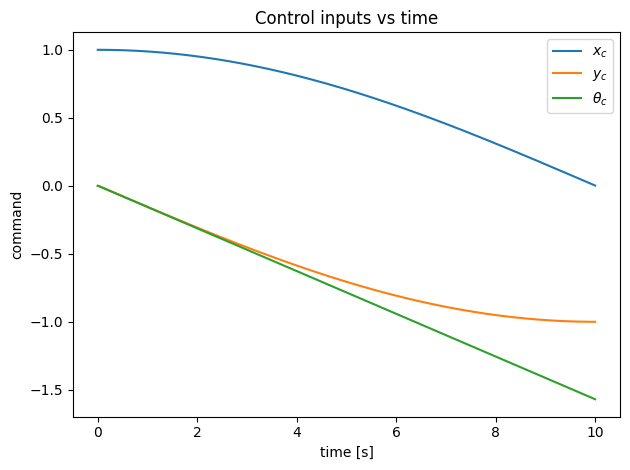

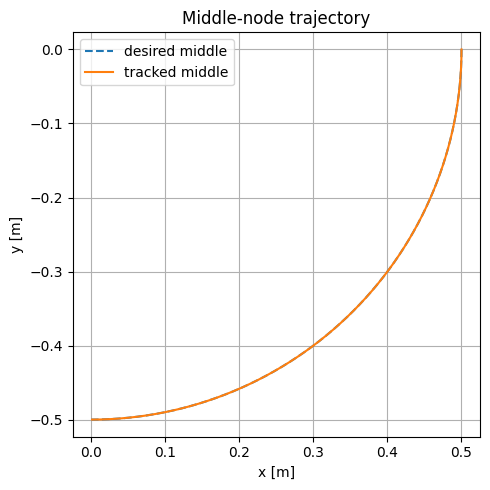

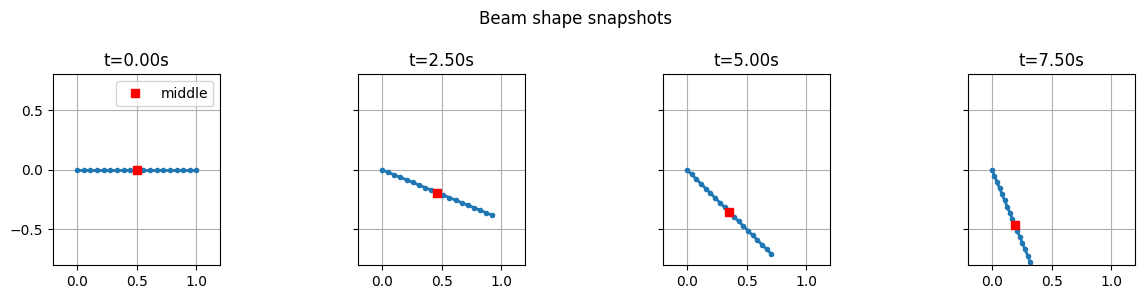

In [19]:
# Main loop
def run_sim():
    # ---- parameters ----
    nv = 19
    midNode = nv//2 + 1
    RodLength = 1.0
    R_outer = 0.013
    R_inner = 0.011
    Y = 70e9
    rho = 2700.0
    dt = 2e-3
    totalTime = 10.0
    Tref = totalTime
    maximum_iter = 60
    deltaL = RodLength/(nv-1)

    nodes, tol, m, mMat, EI, EA, W, C, free_DOF = Initialization(
        nv, RodLength, R_inner, R_outer, Y, rho, gval=9.81
    )

    # initial state
    q = np.zeros(2*nv, dtype=float)
    for c in range(nv):
        q[2*c]   = nodes[c, 0]
        q[2*c+1] = nodes[c, 1]
    u = np.zeros_like(q)

    # control (end pose)
    xc = RodLength
    yc = 0.0
    theta_c = 0.0
    max_rate_pos = 0.4*RodLength
    max_rate_th  = np.deg2rad(45)

    # logs
    nSteps = int(np.round(totalTime/dt))
    tgrid = np.arange(nSteps)*dt
    mid_idx0 = 2*(midNode-1)

    xm_hist = np.zeros(nSteps)
    ym_hist = np.zeros(nSteps)
    xd_hist = np.zeros(nSteps)
    yd_hist = np.zeros(nSteps)
    xc_hist = np.zeros(nSteps)
    yc_hist = np.zeros(nSteps)
    th_hist = np.zeros(nSteps)

    # beam snapshots at 5 times
    snap_times = np.linspace(0.0, totalTime, 5)
    snaps = []
    next_snap = 0

    # gentle ramps for stability
    def ramp(s, T):
        a = np.clip(s/T, 0.0, 1.0)
        return 3*a*a - 2*a*a*a  # smoothstep

    # simulation
    for k, t in enumerate(tgrid):
        xd, yd = middle_target(t, RodLength, Tref=Tref)
        xm = q[mid_idx0]
        ym = q[mid_idx0+1]

        xd_hist[k] = xd; yd_hist[k] = yd
        xm_hist[k] = xm; ym_hist[k] = ym
        xc_hist[k] = xc; yc_hist[k] = yc; th_hist[k] = theta_c

        # P-control towards target with rate limiting
        ex = xd - xm
        ey = yd - ym
        des_xc = xc + 0.35*ex
        des_yc = yc + 0.35*ey
        xc = rate_limit(xc, des_xc, max_rate_pos, dt)
        yc = rate_limit(yc, des_yc, max_rate_pos, dt)

        # orient last segment towards middle node
        dx = max(1e-9, xc - xm)
        dy = yc - ym
        des_th = np.arctan2(dy, dx)
        theta_c = rate_limit(theta_c, des_th, max_rate_th, dt)

        # build q_guess with end pose enforced
        q_guess = q.copy()
        # left clamp
        q_guess[0] = nodes[0,0]
        q_guess[1] = nodes[0,1]
        # right end node
        q_guess[-2] = xc
        q_guess[-1] = yc
        # second-to-last to set orientation
        q_guess[-4] = xc - deltaL*np.cos(theta_c)
        q_guess[-3] = yc - deltaL*np.sin(theta_c)

        # ramp-in gravity & damping to avoid early spikes
        W_scale = ramp(t, 0.15)
        C_scale = 0.2 + 0.8*ramp(t, 0.3)
        W_eff = W * W_scale
        C_eff = C * C_scale

        q_new, flag = objfun(q_guess, q, u, dt, tol, maximum_iter,
                             m, mMat, EI, EA, W_eff, C_eff, deltaL, free_DOF)
        if flag < 0:
            print(f"⚠️ Newton did not converge at step {k} (t={t:.4f}s). Stopping.")
            # trim logs
            xm_hist = xm_hist[:k]; ym_hist = ym_hist[:k]
            xd_hist = xd_hist[:k]; yd_hist = yd_hist[:k]
            xc_hist = xc_hist[:k]; yc_hist = yc_hist[:k]; th_hist = th_hist[:k]
            tgrid = tgrid[:k]
            break

        # velocity (BDF1)
        u = (q_new - q) / dt
        q = q_new

        # take snapshots
        if next_snap < len(snap_times) and t >= snap_times[next_snap] - 0.5*dt:
            snaps.append((t, q.copy()))
            next_snap += 1


    plt.plot(tgrid, xc_hist, label=r'$x_c$')
    plt.plot(tgrid, yc_hist, label=r'$y_c$')
    plt.plot(tgrid, th_hist, label=r'$\theta_c$')
    plt.xlabel('time [s]'); plt.ylabel('command'); plt.title('Control inputs vs time')
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(5,5))
    plt.plot(xd_hist, yd_hist, '--', label='desired middle')
    plt.plot(xm_hist, ym_hist, '-',  label='tracked middle')
    plt.axis('equal'); plt.grid(True)
    plt.xlabel('x [m]'); plt.ylabel('y [m]')
    plt.legend(); plt.title('Middle-node trajectory'); plt.tight_layout(); plt.show()

    if snaps:
        fig,axes = plt.subplots(1,len(snaps), figsize=(3.2*len(snaps),3), sharex=True, sharey=True)
        if len(snaps)==1:
            axes = [axes]
        xmin,xmax = -0.2*RodLength, 1.2*RodLength
        ymin,ymax = -0.8*RodLength, 0.8*RodLength
        for ax,(tt,qq) in zip(axes, snaps):
            xx = qq[::2]; yy = qq[1::2]
            ax.plot(xx, yy, 'o-', lw=2, ms=3)
            ax.plot(xx[midNode-1], yy[midNode-1], 'rs', ms=6,
                    label='middle' if tt==snaps[0][0] else "")
            ax.set_title(f't={tt:.2f}s')
            ax.set_xlim([xmin,xmax]); ax.set_ylim([ymin,ymax]); ax.set_aspect('equal'); ax.grid(True)
        axes[0].legend()
        fig.suptitle('Beam shape snapshots'); plt.tight_layout(); plt.show()

if __name__ == "__main__":
    run_sim()
